# Задание 3. Ансамблевая модель на примере gradient boosting

### 1. Изучить теоретический материал изложенный в статье о градиентном бустинге. Актуальная версия кода в английской версии статьи о градиентном бустинге.

### 2. Реализовать пример визуализации и расчет доверительного интервала для анализа оттока клиентов с помощью bootstrap и baggig (см. примеры в статьях из п. 1).

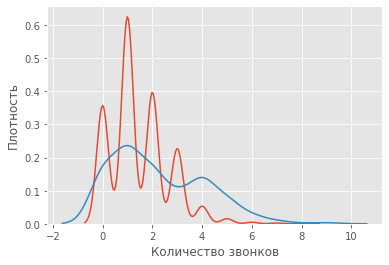

In [85]:
import pandas as pd
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
import seaborn as sns
%matplotlib inline

telecom_data = pd.read_csv('datasets/telecom_churn.csv')

fig = sns.kdeplot(telecom_data[telecom_data['Churn'] == False]['Customer service calls'], label = 'Loyal')
fig = sns.kdeplot(telecom_data[telecom_data['Churn'] == True]['Customer service calls'], label = 'Churn')        
fig.set(xlabel='Количество звонков', ylabel='Плотность')    
plt.show()

In [86]:
import numpy as np
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# сохранение в отдельные numpy массивы данных по лояльным и уже бывшим клиентам
loyal_calls = telecom_data[telecom_data['Churn'] == False]['Customer service calls'].values
churn_calls= telecom_data[telecom_data['Churn'] == True]['Customer service calls'].values

# ставим seed для воспроизводимости результатов
np.random.seed(0)

# генерируем выборки с помощью бутстрэра и сразу считаем по каждой из них среднее
loyal_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(loyal_calls, 1000)]
churn_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(churn_calls, 1000)]

#  выводим интервальную оценку среднего
print("Service calls from loyal:  mean interval",  stat_intervals(loyal_mean_scores, 0.05))
print("Service calls from churn:  mean interval",  stat_intervals(churn_mean_scores, 0.05))

Service calls from loyal:  mean interval [1.4077193  1.49473684]
Service calls from churn:  mean interval [2.0621118  2.39761905]


### 3. Изучить настройку параметров для градиентного бустинга в Gradient Boosting Interactive Playground

### 4. Изучить и реализовать примеры из статьи Градиентый бустинг — просто о сложном

In [87]:
%matplotlib inline

from IPython.display import display
from fastai.imports import *
from sklearn import metrics

In [88]:
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [89]:
x = np.arange(0,50)
x = pd.DataFrame({'x':x})

# just random uniform distributions in differnt range

y1 = np.random.uniform(10,15,10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)

y = np.concatenate((y1,y2,y3,y4,y5))
y = y[:,None]

In [90]:
class DecisionTree():
    def __init__(self, x, y, idxs = None, min_leaf=2):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

### Data simulation

In [91]:
x = np.arange(0,50)
x = pd.DataFrame({'x':x})

In [92]:
# just random uniform distributions in differnt range

y1 = np.random.uniform(10,15,10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)

y = np.concatenate((y1,y2,y3,y4,y5))
y = y[:,None]

### Scatter plot of data

In [93]:
x.shape, y.shape

((50, 1), (50, 1))

In [94]:
x.head(), y[:5]

(   x
 0  0
 1  1
 2  2
 3  3
 4  4,
 array([[11.32167258],
        [13.98813823],
        [12.24989679],
        [13.33553465],
        [11.76525234]]))

### Visualization

InvalidIndexError: (slice(None, None, None), None)

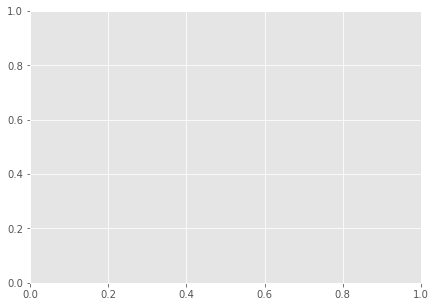

In [97]:
plt.figure(figsize=(7,5))
plt.plot(x,y, 'o')
plt.title("Scatter plot of x vs. y")
plt.xlabel("x")
plt.ylabel("y")
plt.show()



InvalidIndexError: (slice(None, None, None), None)

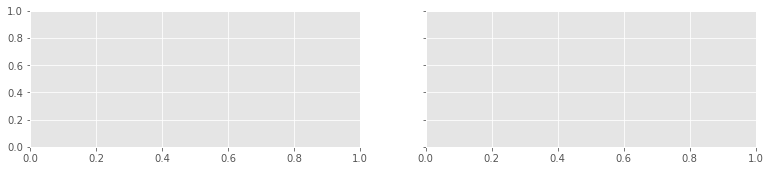

In [96]:
xi = x # initialization of input
yi = y # initialization of target
# x,y --> use where no need to change original y
ei = 0 # initialization of error
n = len(yi)  # number of rows
predf = 0 # initial prediction 0

for i in range(30): # like n_estimators
    tree = DecisionTree(xi,yi)
    tree.find_better_split(0)
    
    r = np.where(xi == tree.split)[0][0]    
    
    left_idx = np.where(xi <= tree.split)[0]
    right_idx = np.where(xi > tree.split)[0]
    
    predi = np.zeros(n)
    np.put(predi, left_idx, np.repeat(np.mean(yi[left_idx]), r))  # replace left side mean y
    np.put(predi, right_idx, np.repeat(np.mean(yi[right_idx]), n-r))  # right side mean y
    
    predi = predi[:,None]  # make long vector (nx1) in compatible with y
    predf = predf + predi  # final prediction will be previous prediction value + new prediction of residual
    
    ei = y - predf  # needed originl y here as residual always from original y    
    yi = ei # update yi as residual to reloop
    
    
    # plotting after prediction
    xa = np.array(x.x) # column name of x is x 
    order = np.argsort(xa)
    xs = np.array(xa)[order]
    ys = np.array(predf)[order]
    
    #epreds = np.array(epred[:,None])[order]

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (13,2.5))

    ax1.plot(x,y, 'o')
    ax1.plot(xs, ys, 'r')
    ax1.set_title(f'Prediction (Iteration {i+1})')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y / y_pred')

    ax2.plot(x, ei, 'go')
    ax2.set_title(f'Residuals vs. x (Iteration {i+1})')
    ax2.set_xlabel('x')
    ax2.set_ylabel('Residuals')

### Изучить и реализовать примеры из статьи Решаем задачи машинного обучения с помощью алгоритма градиентного бустинга

#### Реализация на языке python (библиотека sklearn)

In [98]:
### Загружаем библиотеки и данные
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import mean_squared_error,r2_score 

import warnings
warnings.filterwarnings('ignore')
breast_cancer = load_breast_cancer()


### Обозначаем целевую переменную для нашей будущей модели
X = pd.DataFrame(breast_cancer['data'], columns=breast_cancer['feature_names'])
y = pd.Categorical.from_codes(breast_cancer['target'], breast_cancer['target_names'])

lbl = LabelEncoder() 
lbl.fit(y)

y_enc = lbl.transform(y)


### Разбираемся с признаками
scl = StandardScaler()
scl.fit(X)
X_scaled = scl.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.20, random_state=42)


### Прописываем параметры для нашей модели 
params = {'n_estimators':200,
          'max_depth':12,
          'criterion':'mse',
          'learning_rate':0.03,
          'min_samples_leaf':16,
          'min_samples_split':16
          }


### Тренируем
gbr = GradientBoostingRegressor(**params)
gbr.fit(X_train,y_train)


### Вычисляем точность
train_accuracy_score=gbr.score(X_train,y_train)
print(train_accuracy_score)

test_accuracy_score=gbr.score(X_test,y_test)
print(test_accuracy_score)

### Предсказание
y_pred = gbr.predict(X_test)

### И среднеквадратичную ошибку
mse = mean_squared_error(y_test,y_pred)
print("MSE: %.2f" % mse)
print(r2_score(y_test,y_pred))

0.9852634686710425
0.8734762491039207
MSE: 0.03
0.8734762491039207


#### Пример использования XGBoost для классификации:

In [99]:
# xgboost для классификации
from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
# определяем датасет
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# и нашу модель вместе с кросс-валидацией
model = XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Точность: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# тренируем модель на всём наборе данных
model = XGBClassifier()
model.fit(X, y)
# предсказываем
row = [2.56999479, -0.13019997, 3.16075093, -4.35936352, -1.61271951, -1.39352057, -2.48924933, -1.93094078, 3.26130366, 2.05692145]
row = asarray(row).reshape((1, len(row)))
yhat = model.predict(row)
print('Предсказание (Предикт): %d' % yhat[0])

Точность: 0.936 (0.019)
Предсказание (Предикт): 1


#### Пример использования XGBoost для регрессии:

In [100]:
# xgboost для регрессии
from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
# определяем датасет
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# и нашу модель (в данном примере мы меняем метрику на MAE)
model = XGBRegressor(objective='reg:squarederror')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE (Средняя Абсолютная Ошибка): %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# тренируем модель на всём наборе данных
model = XGBRegressor(objective='reg:squarederror')
model.fit(X, y)
# предсказываем
row = [2.02220122, 0.31563495, 0.82797464, -0.30620401, 0.16003707, -1.44411381, 0.87616892, -0.50446586, 0.23009474, 0.76201118]
row = asarray(row).reshape((1, len(row)))
yhat = model.predict(row)
print('Предсказание (Предикт): %.3f' % yhat[0])

MAE (Средняя Абсолютная Ошибка): -15.048 (1.316)
Предсказание (Предикт): -93.434


#### LightGBM для классификации:

In [1]:
# lightgbm для классификации
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
# определяем датасет
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# и нашу модель
model = LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Точность: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# тренируем модель на всём наборе данных
model = LGBMClassifier()
model.fit(X, y)
# предсказываем
row = [[2.56999479, -0.13019997, 3.16075093, -4.35936352, -1.61271951, -1.39352057, -2.48924933, -1.93094078, 3.26130366, 2.05692145]]
yhat = model.predict(row)
print('Предсказание (Предикт): %d' % yhat[0])

Точность: 0.934 (0.021)
Предсказание (Предикт): 1


#### LightGBM для регрессии:

In [2]:
# lightgbm для регрессии
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
# определяем датасет
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# и нашу модель (в данном примере мы меняем метрику на MAE)
model = LGBMRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE (Средняя Абсолютная Ошибка): %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# тренируем модель на всём наборе данных
model = LGBMRegressor()
model.fit(X, y)
# предсказываем
row = [[2.02220122, 0.31563495, 0.82797464, -0.30620401, 0.16003707, -1.44411381, 0.87616892, -0.50446586, 0.23009474, 0.76201118]]
yhat = model.predict(row)
print('Предсказание (Предикт): %.3f' % yhat[0])

MAE (Средняя Абсолютная Ошибка): -12.739 (1.408)
Предсказание (Предикт): -82.040


#### CatBoost в задаче классификации:

In [4]:
# catboost для классификации
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
# определяем датасет
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# evaluate the model
model = CatBoostClassifier(verbose=0, n_estimators=100)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Точность: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# тренируем модель на всём наборе данных
model = CatBoostClassifier(verbose=0, n_estimators=100)
model.fit(X, y)
# предсказываем
row = [[2.56999479, -0.13019997, 3.16075093, -4.35936352, -1.61271951, -1.39352057, -2.48924933, -1.93094078, 3.26130366, 2.05692145]]
yhat = model.predict(row)
print('Предсказание (Предикт): %d' % yhat[0])

Точность: 0.925 (0.025)
Предсказание (Предикт): 1


#### CatBoost в задаче регрессии:

In [5]:
# catboost для регрессии
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot
# определяем датасет
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# и нашу модель (в данном примере мы меняем метрику на MAE)
model = CatBoostRegressor(verbose=0, n_estimators=100)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE (Средняя Абсолютная Ошибка): %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# тренируем модель на всём наборе данных
model = CatBoostRegressor(verbose=0, n_estimators=100)
model.fit(X, y)
# предсказываем
row = [[2.02220122, 0.31563495, 0.82797464, -0.30620401, 0.16003707, -1.44411381, 0.87616892, -0.50446586, 0.23009474, 0.76201118]]
yhat = model.predict(row)
print('Предсказание (Предикт): %.3f' % yhat[0])

MAE (Средняя Абсолютная Ошибка): -9.701 (1.234)
Предсказание (Предикт): -81.905
